<a href="https://colab.research.google.com/github/zskylarli/transcrobialGAN/blob/main/similarity_transcrobial_pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transcrobial GAN

*PyTorch implementation*

Author: Skylar Li 

Used datasets:

- https://www.dropbox.com/sh/g8w03sfarsg979b/AAB2cVzUdabKH-NdAT1YBevIa?dl=0



# Install

# Dataset

Upload dataset to Google Drive folder. 

In [1]:
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

# import for image cropping
import cv2
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH_OF_DATA= '/content/drive/MyDrive/transcrobialGAN'
!ls {PATH_OF_DATA}

 02162022_new   03032022_new   JPEGs_ALL
 02212022_new   03032022_old  'Transcrobial Images Dataset Sorting.gsheet'


In [5]:
import os

old_path = '/content/drive/MyDrive/transcrobialGAN/03032022_old'
new_path = '/content/drive/MyDrive/transcrobialGAN/03032022_new'

list_of_files = []
with os.scandir(old_path) as it:
  for entry in it:
    if entry.is_file():
      list_of_files.append(entry.name)

print(len(list_of_files))

162


In [76]:
counter = 1;
for file in list_of_files:
  usage = ''

  img = cv2.imread(os.path.join(old_path,file))
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  canny = cv2.Canny(blurred, 150, 300, L2gradient = True)

  pts = np.argwhere(canny>0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)

  cropped = img[y1:y2, x1:x2]

  # if counter % 2 == 0:
  #   usage = 'A';
  # else:
  #   usage = 'B';
  
  folder_path = new_path
  
  file = file.split('.jpg')
  file = file[0] + '.png'
  image_name = file
  new_image_path = os.path.join(folder_path,image_name)
  cv2.imwrite(new_image_path, cropped)

  # bug with 1.5%BKE35360_3, 1.5%BKE35360_4 - !!!

  counter += 1;

In [148]:
  # bug with 1.5%BKE35360_3, 1.5%BKE35360_4 - until fixed, use this to manually crop and move 

  img = cv2.imread(os.path.join(old_path,'1.5%BKE35360_4.jpg'))
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  canny = cv2.Canny(blurred, 150, 300, L2gradient = True)

  pts = np.argwhere(canny>0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)

  cropped = img[y1:y2, x1:x2]
  
  cv2.imwrite('/content/drive/MyDrive/transcrobialGAN/03032022_new/1.5%BKE35360_4.png', cropped)

  img = cv2.imread(os.path.join(old_path,'1.5%BKE35360_3.jpg'))
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  canny = cv2.Canny(blurred, 150, 300, L2gradient = True)

  pts = np.argwhere(canny>0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)

  cropped = img[y1:y2, x1:x2]
  
  cv2.imwrite('/content/drive/MyDrive/transcrobialGAN/03032022_new/1.5%BKE35360_3.png', cropped)

True

In [151]:
path = new_path

bacteria = []
with os.scandir(path) as it:
  for entry in it:
    if entry.is_file():
      bacteria.append(entry.name)
    else:
      print(entry.name)

# change the working directory to the path where the images are located
os.chdir(path)

print(len(bacteria))

162


In [152]:
# VGG16
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features
   
data = {}

# lop through each image in the dataset
for b in bacteria:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(b,model)
        data[b] = feat
    except:
        print('failed1')
          
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=81, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [158]:
# cluster feature vectors
clusters = 20
kmeans = KMeans(n_clusters=clusters,random_state=22)
kmeans.fit(x)

# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

# function that lets you view a cluster (input cluster number)      
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off') 
    plt.show()

Cluster 0


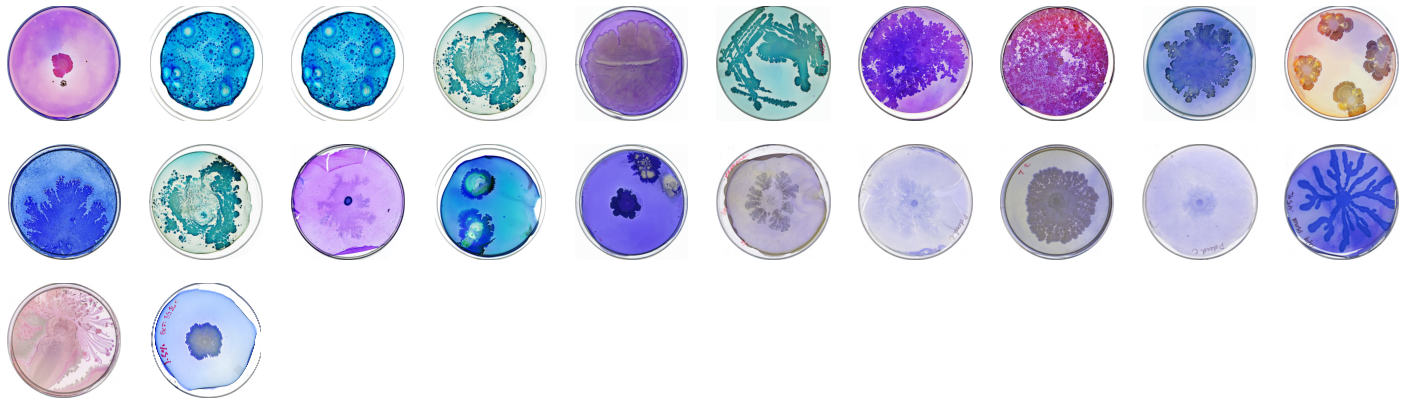

------------------
Cluster 1


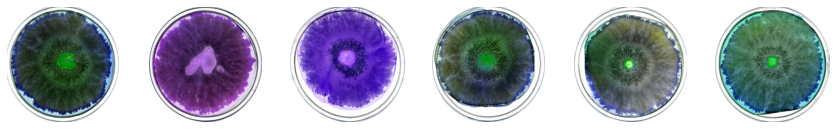

------------------
Cluster 2


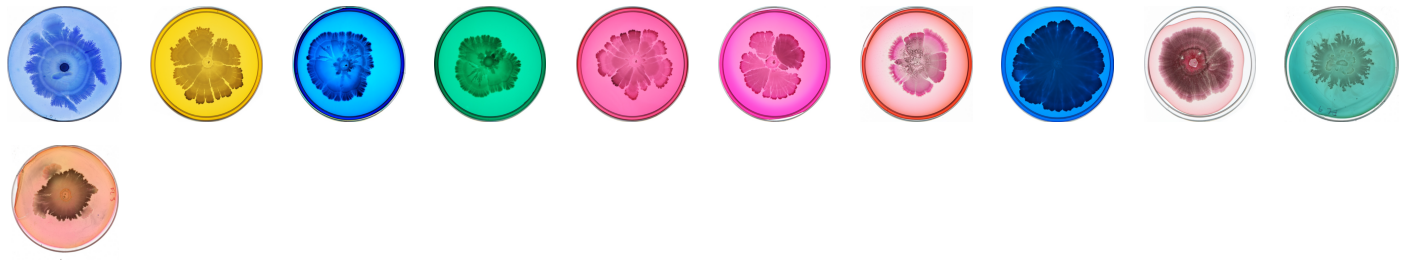

------------------
Cluster 3


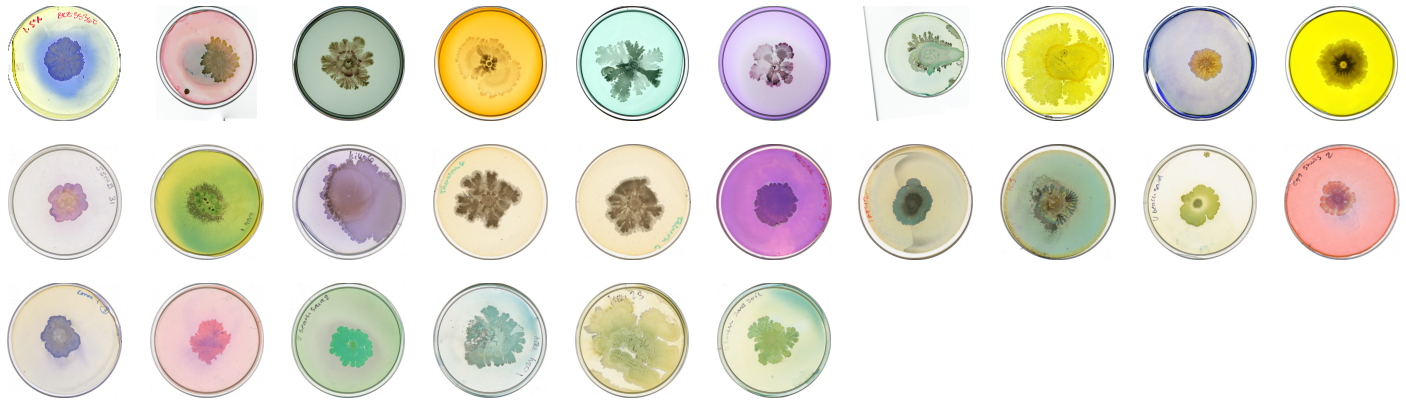

------------------
Cluster 4


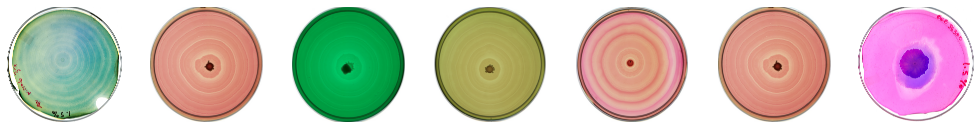

------------------
Cluster 5


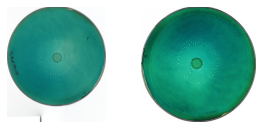

------------------
Cluster 6


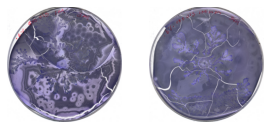

------------------
Cluster 7


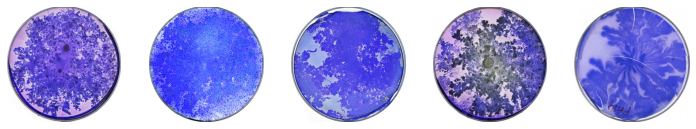

------------------
Cluster 8


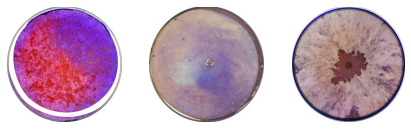

------------------
Cluster 9


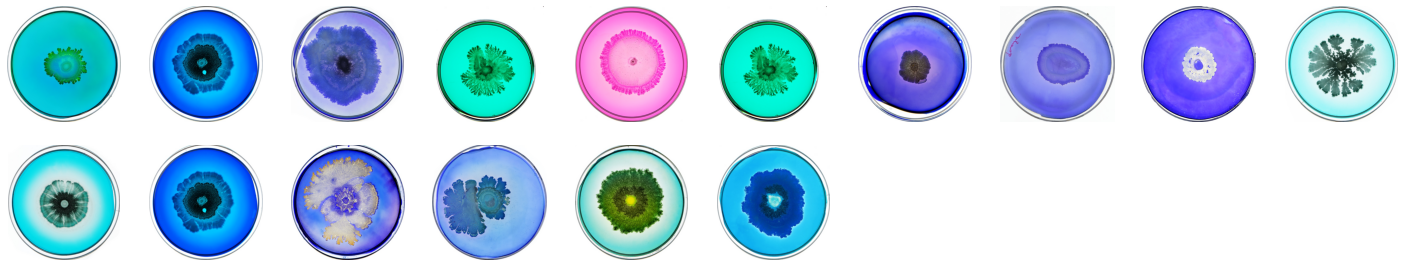

------------------
Cluster 10


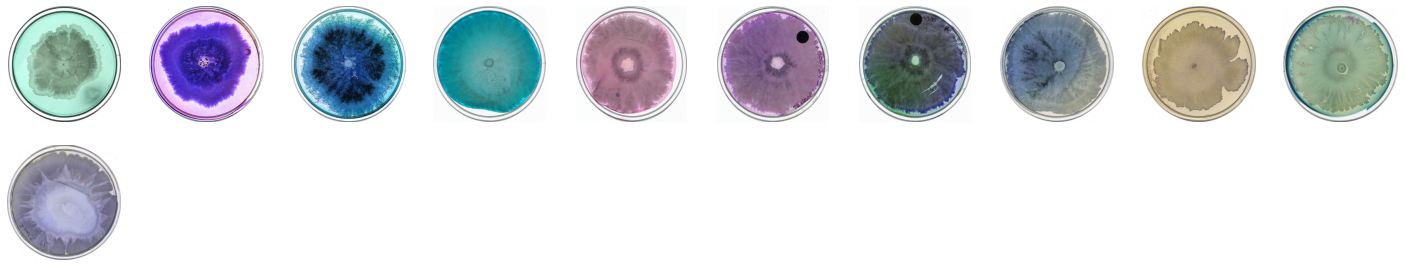

------------------
Cluster 11


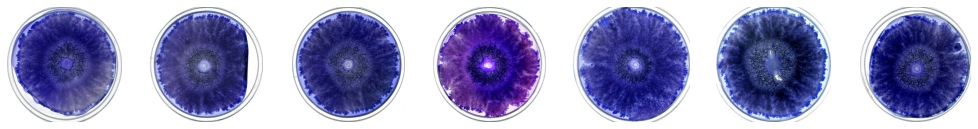

------------------
Cluster 12


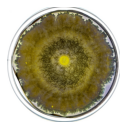

------------------
Cluster 13


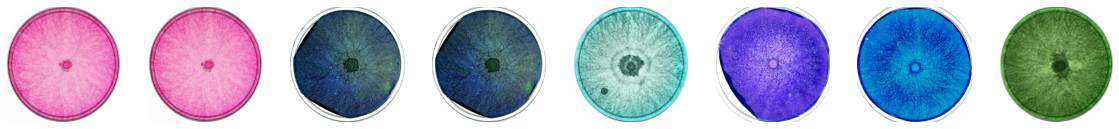

------------------
Cluster 14


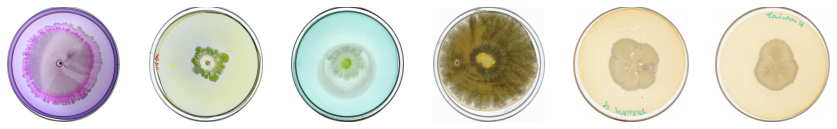

------------------
Cluster 15


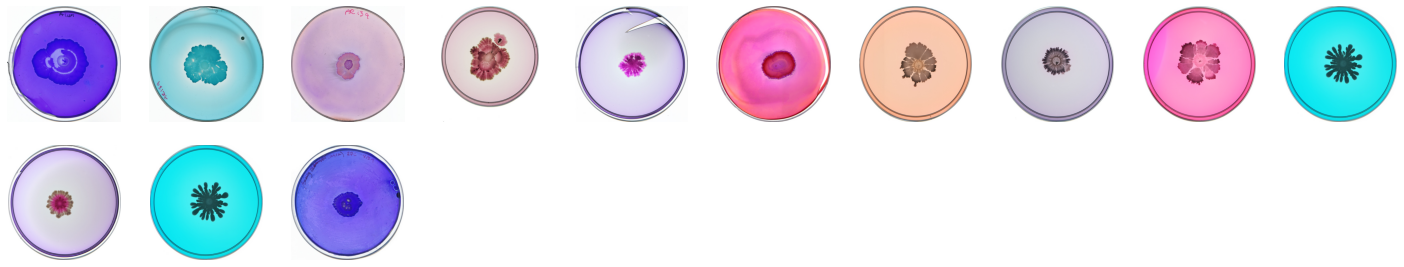

------------------
Cluster 16


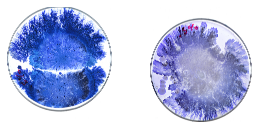

------------------
Cluster 17


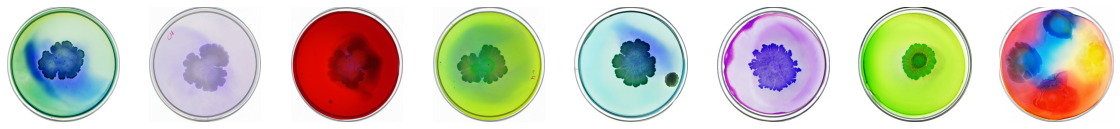

------------------
Cluster 18


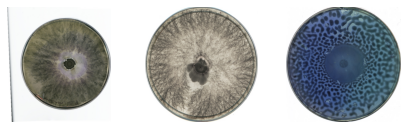

------------------
Cluster 19


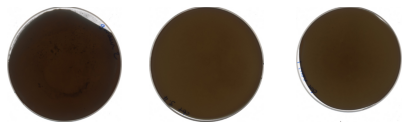

------------------


In [159]:
for i in range(clusters):
  print('Cluster ' + str(i))
  view_cluster(i)
  print('------------------')


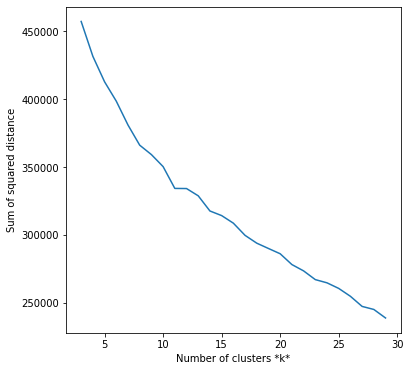

In [155]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(3, 30))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [160]:
def resize_img(img):
  width = 700
  height = 720
  dim = (width, height)
  resized = cv2.resize(img, dim)
  return resized

def image_write(path_A, path_B, path_AB):
    im_A = cv2.imread(path_A, 1) 
    im_A = resize_img(im_A)
    im_B = cv2.imread(path_B, 1) 
    im_B = resize_img(im_B)
    im_AB = np.concatenate([im_A, im_B], 1)

    cv2.imwrite(path_AB, im_AB)

In [176]:
import math

def comb_images(path, clusters):
  n_pairs = 0;
  unpaired = []

  path_AB = path +'/AB'
  if not os.path.isdir(path_AB):
    os.mkdir(path_AB)

  for i in range(len(clusters)):
    for j in range(len(clusters[i])):
        img_path_A = clusters[i][j]
        k = 0-j-1
        img_path_B = clusters[i][k]
        if img_path_A == img_path_B:
          unpaired.append(img_path_A)
        else:
          img_path_AB= path_AB + '/' + str(n_pairs) + '_comb.png'
          n_pairs += 1
          image_write(img_path_A, img_path_B, img_path_AB)

  nn_pairs = n_pairs + 1;

  for m in range(len(unpaired)):
    img_path_A = unpaired[m]
    n = 0-m-1
    img_path_B = unpaired[n]
    img_path_AB= path_AB + '/' + str(nn_pairs) + '_comb.png'
    nn_pairs += 1
    image_write(img_path_A, img_path_B, img_path_AB)
  
  print(n_pairs)
  print(nn_pairs)
  print(unpaired)

In [177]:
comb_images(new_path, groups)

152
163
['fwplate.png', 'mirab.3.png', 'dot red 4.png', 'e.coli_2.png', 'web5.png', 'web16.png', 'web22.png', 'fw plate 1.2.png', 'web.1.png', '25028.png']


In [178]:
import numpy as np
import shutil

def split_train_test(path_name, split_ratio):
  rootdir = new_path + '/' + path_name;

  allFileNames = os.listdir(rootdir)

  np.random.shuffle(allFileNames)

  test_ratio = split_ratio

  train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                        [int(len(allFileNames)* (1 - test_ratio))])

  train_FileNames = [rootdir+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [rootdir+'/' + name for name in test_FileNames.tolist()]

  print('Total images: ', len(allFileNames))
  print('Training: ', len(train_FileNames))
  print('Testing: ', len(test_FileNames))

  i = 1;
  j = len(train_FileNames)+1;

  os.makedirs(rootdir +'/train/')
  os.makedirs(rootdir +'/test/')

  for name in train_FileNames:
    new_name = rootdir + '/train/' + str(i) + '.png';
    os.rename(name, new_name)
    i += 1;

  for name in test_FileNames:
    new_name = rootdir + '/test/' + str(j) + '.png';
    os.rename(name, new_name)
    j += 1;

In [179]:
split_train_test('AB',0.2)

Total images:  162
Training:  129
Testing:  33


# Training

-   `python train.py --dataroot /content/gdrive/"My Drive"/finalproject/AB --name dibas_pix2pix --model pix2pix --direction BtoA`

Change the `--dataroot` and `--name` to your own dataset's path and model's name. Use `--gpu_ids 0,1,..` to train on multiple GPUs and `--batch_size` to change the batch size. Add `--direction BtoA` if you want to train a model to transfrom from class B to A.

In [19]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
os.chdir('pytorch-CycleGAN-and-pix2pix/')
!pip install -r requirements.txt

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2447, done.
remote: Total 2447 (delta 0), reused 0 (delta 0), pack-reused 2447
Receiving objects: 100% (2447/2447), 8.18 MiB | 8.79 MiB/s, done.
Resolving deltas: 100% (1535/1535), done.


In [182]:
!python train.py --dataroot /content/drive/MyDrive/transcrobialGAN/03032022_new/AB --name transcrobial_pix2pix --model pix2pix --direction BtoA

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/transcrobialGAN/03032022_new/AB	[default: None]
             dataset_mode: aligned                       
                direction: BtoA                          	[default: AtoB]
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: lates

# Testing

-   `python test.py --dataroot ./datasets/facades --direction BtoA --model pix2pix --name facades_pix2pix`

Change the `--dataroot`, `--name`, and `--direction` to be consistent with your trained model's configuration and how you want to transform images.


In [16]:
checkpoints = /content/drive/MyDrive/transcrobialGAN/03032022_new/pytorch-CycleGAN-and-pix2pix/checkpoints/transcrobial_pix2pix/latest_net_G.pth
!ls {checkpoints}
os.chdir(checkpoints)

transcrobial_pix2pix


In [21]:
!python test.py --dataroot /content/drive/MyDrive/transcrobialGAN/03032022_new/AB --direction BtoA --model pix2pix --name transcrobial_pix2pix 

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/transcrobialGAN/03032022_new/AB	[default: None]
             dataset_mode: aligned                       
                direction: BtoA                          	[default: AtoB]
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                

# Save results to My Drive

In [186]:
!zip -r /content/drive/MyDrive/transcrobialGAN/03032022_new/results /content/pytorch-CycleGAN-and-pix2pix/results/transcrobial_pix2pix/test_latest/images

	zip warning: name not matched: /content/pytorch-CycleGAN-and-pix2pix/results/transcrobial_pix2pix/test_latest/images

zip error: Nothing to do! (try: zip -r /content/drive/MyDrive/transcrobialGAN/03032022_new/results . -i /content/pytorch-CycleGAN-and-pix2pix/results/transcrobial_pix2pix/test_latest/images)
